In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
deliveries = pd.read_csv("/content/deliveries.csv")
matches = pd.read_csv("/content/matches (1).csv")

In [ ]:
total_score_df = deliveries.groupby(["match_id", "inning"]).sum()["total_runs"].reset_index()
total_score_df = total_score_df[total_score_df["inning"] == 1]

In [ ]:
match_df= matches.merge(total_score_df[["match_id" , "total_runs"]] , left_on = "id" , right_on = "match_id")

In [ ]:
match_df["team1"].unique()

array(['Sunrisers Hyderabad', 'Mumbai Indians', 'Gujarat Lions',
       'Rising Pune Supergiant', 'Royal Challengers Bangalore',
       'Kolkata Knight Riders', 'Delhi Daredevils', 'Kings XI Punjab',
       'Chennai Super Kings', 'Rajasthan Royals', 'Deccan Chargers',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Rising Pune Supergiants'],
      dtype=object)

In [ ]:
teams = [
    "Sunrisers Hyderabad",
    "Mumbai Indians",
    "Royal Challengers Bangalore",
    "Kolkata Knight Riders",
    "Kings XI Punjab",
    "Chennai Super Kings",
    "Rajasthan Royals",
    "Delhi Capitals"
]

In [ ]:
match_df["team1"] = match_df["team1"].str.replace("Delhi Daredevils" , "Delhi Capitals")
match_df["team2"] = match_df["team2"].str.replace("Delhi Daredevils" , "Delhi Capitals")

match_df["team1"] = match_df["team1"].str.replace("Deccan Chargers" , "Sunrisers Hyderabad")
match_df["team2"] = match_df["team2"].str.replace("Deccan Chargers" , "Sunrisers Hyderabad")

In [ ]:
match_df = match_df[match_df["team1"].isin(teams)]
match_df = match_df[match_df["team2"].isin(teams)]

In [ ]:
match_df.shape

(582, 20)

In [ ]:
match_df = match_df[match_df["dl_applied"] == 0]

In [ ]:
match_df = match_df[["match_id" , "city" , "winner" , "total_runs"]]

In [ ]:
delivery_df = match_df.merge(deliveries , on = "match_id")

In [ ]:
delivery_df =delivery_df[delivery_df["inning"] == 2]

In [ ]:
delivery_df.shape

(65433, 24)

In [ ]:
delivery_df["current_score"] = delivery_df.groupby("match_id")["total_runs_y"].cumsum()


In [ ]:
delivery_df["runs_left"] = delivery_df["total_runs_x"] -  delivery_df["current_score"]

In [ ]:
delivery_df["balls_left"] = 126 - (delivery_df["over"]*6 + delivery_df["ball"])

In [ ]:
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna("0")
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].apply(lambda x:x if x == "0" else "1")
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].astype('int')
wickets = delivery_df.groupby('match_id')['player_dismissed'].cumsum().values
delivery_df['wickets'] = 10 - wickets


In [ ]:
# current_runrate = runs / overs
delivery_df["crr"] = (delivery_df["current_score"]*6)/(120 - delivery_df["balls_left"])

In [ ]:
# required runrate
delivery_df["rrr"] = (delivery_df["runs_left"] * 6) / delivery_df["balls_left"]

In [ ]:
def result(row):
  return 1 if row["batting_team"] == row["winner"] else 0

In [ ]:
delivery_df["result"] = delivery_df.apply(result , axis = 1)

In [ ]:
final_df = delivery_df[['batting_team','bowling_team','city','runs_left','balls_left','wickets','total_runs_x','crr','rrr','result']]

In [ ]:
final_df = final_df.sample(final_df.shape[0])

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
final_df.dropna(inplace=True)

In [ ]:
final_df = final_df[final_df["balls_left"] != 0]

In [ ]:
from typing_extensions import final
x = final_df.iloc[: ,:-1]
y  = final_df.iloc[: , -1]

In [ ]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.2 , random_state=1)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

trf = ColumnTransformer([
    ('trf',OneHotEncoder(sparse_output=False,drop='first'),['batting_team','bowling_team','city'])
]
,remainder='passthrough')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [ ]:
pipe = Pipeline(steps=[
    ("step1" , trf),
    ("step2" , LogisticRegression(solver="liblinear"))

])

In [ ]:
pipe.fit(x_train , y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('step2', LogisticRegression(solver='liblinear'))])

In [ ]:
y_pred  = pipe.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test  , y_pred )

0.808495767647744

In [ ]:
def match_progression(x_df,match_id,pipe):
    match = x_df[x_df['match_id'] == match_id]
    match = match[(match['ball'] == 6)]
    temp_df = match[['batting_team','bowling_team','city','runs_left','balls_left','wickets','total_runs_x','crr','rrr']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0]
    result = pipe.predict_proba(temp_df)
    temp_df['lose'] = np.round(result.T[0]*100,1)
    temp_df['win'] = np.round(result.T[1]*100,1)
    temp_df['end_of_over'] = range(1,temp_df.shape[0]+1)

    target = temp_df['total_runs_x'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0,target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)
    wickets = list(temp_df['wickets'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0,10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]

    print("Target-",target)
    temp_df = temp_df[['end_of_over','runs_after_over','wickets_in_over','lose','win']]
    return temp_df,target

In [ ]:

temp_df,target = match_progression(delivery_df,74,pipe)
temp_df

Target- 178.0


,end_of_over,runs_after_over,wickets_in_over,lose,win
10459,1,4.0,0,57.1,42.9
10467,2,8.0,0,50.9,49.1
10473,3,1.0,0,58.4,41.6
10479,4,7.0,1,69.4,30.6
10485,5,12.0,0,58.7,41.3
10491,6,13.0,0,45.8,54.2
10497,7,9.0,0,39.9,60.1
10505,8,15.0,0,26.0,74.0
10511,9,7.0,0,24.0,76.0
10518,10,17.0,0,12.8,87.2


Text(0.5, 1.0, 'Target-178.0')

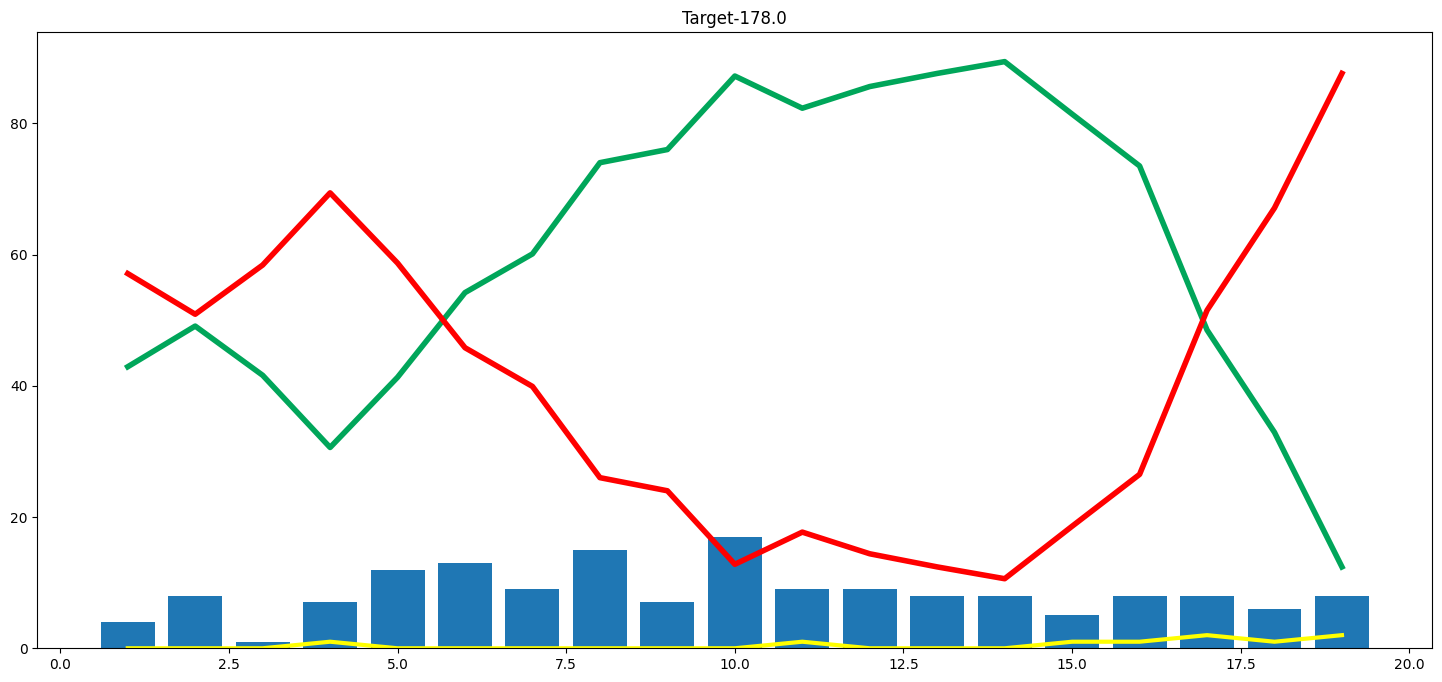

In [ ]:

import matplotlib.pyplot as plt
plt.figure(figsize=(18,8))
plt.plot(temp_df['end_of_over'],temp_df['wickets_in_over'],color='yellow',linewidth=3)
plt.plot(temp_df['end_of_over'],temp_df['win'],color='#00a65a',linewidth=4)
plt.plot(temp_df['end_of_over'],temp_df['lose'],color='red',linewidth=4)
plt.bar(temp_df['end_of_over'],temp_df['runs_after_over'])
plt.title('Target-' + str(target))

In [ ]:
teams

['Sunrisers Hyderabad',
 'Mumbai Indians',
 'Royal Challengers Bangalore',
 'Kolkata Knight Riders',
 'Kings XI Punjab',
 'Chennai Super Kings',
 'Rajasthan Royals',
 'Delhi Capitals']

In [ ]:
delivery_df["ciyt"]

In [ ]:
import pickle
pickle.dump(pipe,open('pipe.pkl','wb'))